# EDA: OUSD Student Chronic Absenteeism

Exploratory data analysis on `evaldata_cleaned.csv` — 256,865 student-year rows across 7 school years (2017-18 through 2023-24).

## 1. Setup & Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

df = pd.read_csv('../data/evaldata_cleaned.csv')
print(f'Full dataset: {df.shape[0]:,} rows, {df.shape[1]} columns')
print(f'Students: {df["ANON_ID"].nunique():,}')
print(f'Years: {sorted(df["year"].unique())}')

# Filter to target year and enrolled students
df24 = df[(df['year'] == 2324) & (df['AttRate'].notna())].copy()
print(f'\n2023-24 enrolled rows: {len(df24):,}')

Full dataset: 256,865 rows, 31 columns
Students: 36,695
Years: [np.int64(1718), np.int64(1819), np.int64(1920), np.int64(2021), np.int64(2122), np.int64(2223), np.int64(2324)]

2023-24 enrolled rows: 35,917


## 2. Target Distribution

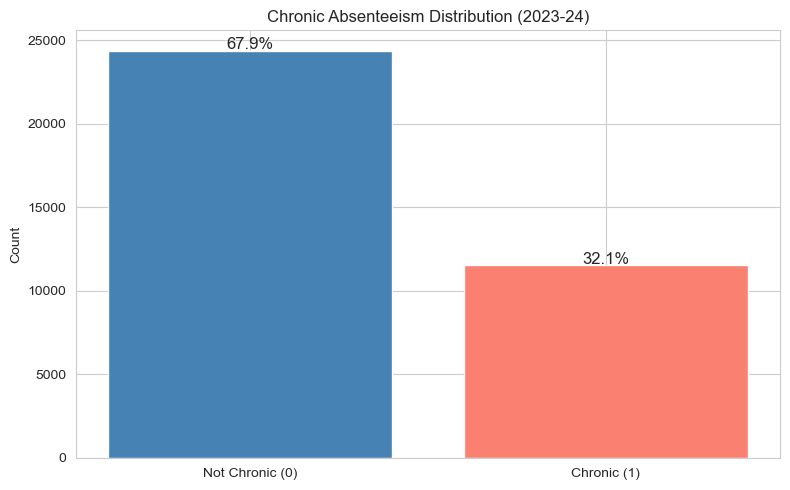

Chronic absence rate: 32.1%


In [2]:
# Chronic absence counts for 2023-24
counts = df24['chronic_absent'].value_counts().sort_index()
labels = ['Not Chronic (0)', 'Chronic (1)']
pcts = counts / counts.sum() * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(labels, counts.values, color=['steelblue', 'salmon'])
for bar, pct in zip(bars, pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
            f'{pct:.1f}%', ha='center', fontsize=12)
ax.set_ylabel('Count')
ax.set_title('Chronic Absenteeism Distribution (2023-24)')
plt.tight_layout()
plt.show()

print(f'Chronic absence rate: {pcts.iloc[1]:.1f}%')

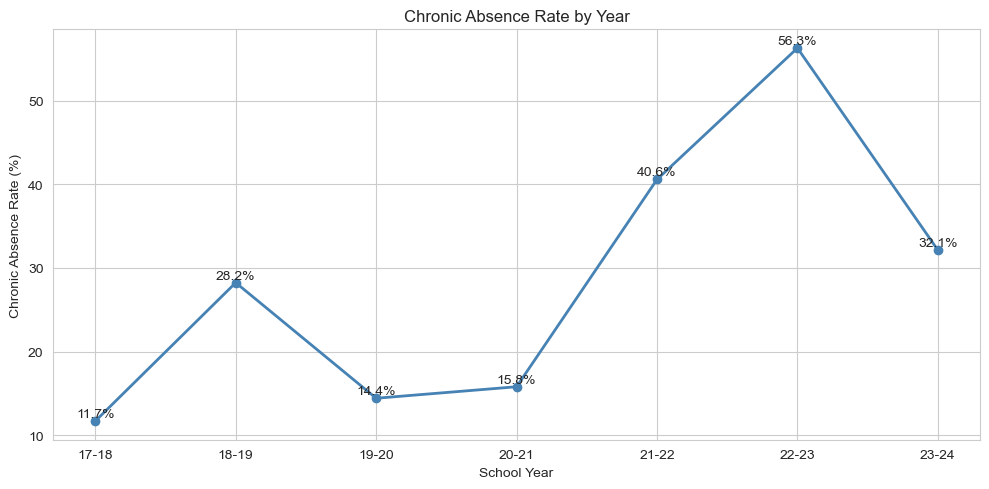

In [3]:
# Chronic absence rate trend across years
enrolled = df[df['AttRate'].notna()].copy()
yearly = enrolled.groupby('year')['chronic_absent'].mean() * 100

year_labels = ['17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24']

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(year_labels, yearly.values, marker='o', linewidth=2, color='steelblue')
for i, v in enumerate(yearly.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)
ax.set_ylabel('Chronic Absence Rate (%)')
ax.set_xlabel('School Year')
ax.set_title('Chronic Absence Rate by Year')
plt.tight_layout()
plt.show()

## 3. Demographic Breakdowns (2023-24)

In [4]:
def plot_chronic_rate_by(col, title=None, figsize=(14, 6), min_n=30):
    """Bar chart of chronic absence rate by a categorical column."""
    grouped = df24.groupby(col)['chronic_absent'].agg(['mean', 'count'])
    grouped = grouped[grouped['count'] >= min_n].sort_values('mean', ascending=False)
    grouped['mean'] *= 100

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(grouped.index.astype(str), grouped['mean'], color='steelblue')
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{row["mean"]:.1f}%\n(n={int(row["count"])})',
                ha='center', fontsize=9)
    ax.set_ylabel('Chronic Absence Rate (%)')
    ax.set_title(title or f'Chronic Absence Rate by {col} (2023-24)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

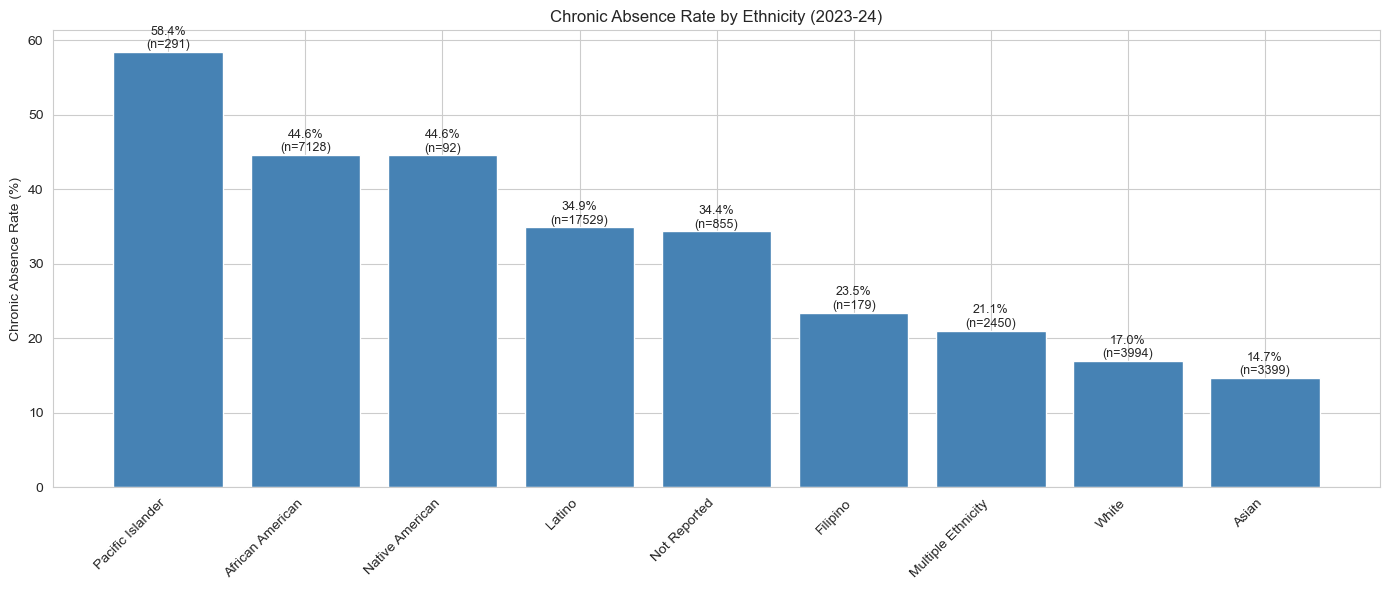

In [5]:
plot_chronic_rate_by('Eth', 'Chronic Absence Rate by Ethnicity (2023-24)')

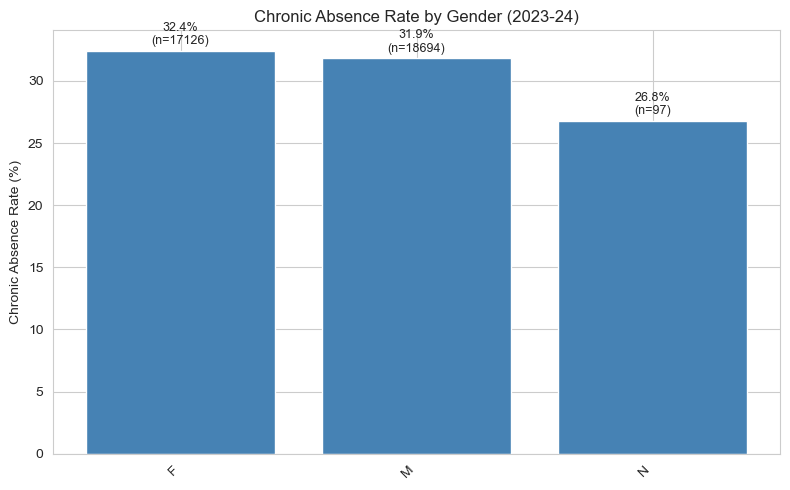

In [6]:
plot_chronic_rate_by('Gen', 'Chronic Absence Rate by Gender (2023-24)', figsize=(8, 5))

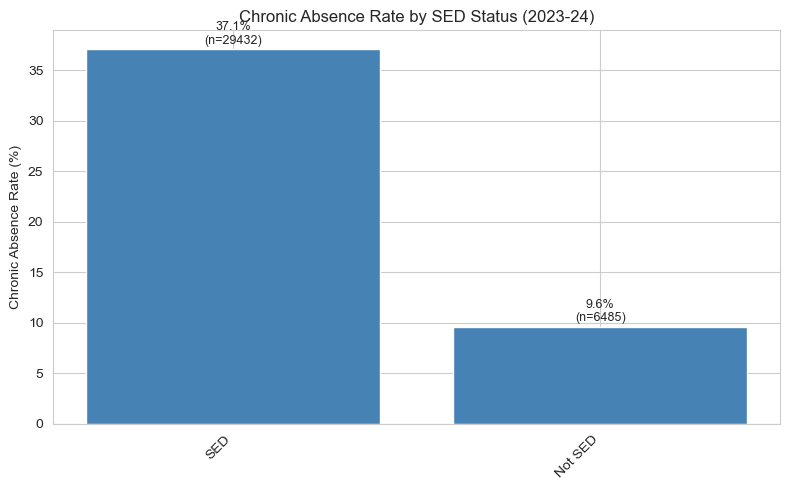

In [7]:
plot_chronic_rate_by('SED', 'Chronic Absence Rate by SED Status (2023-24)', figsize=(8, 5))

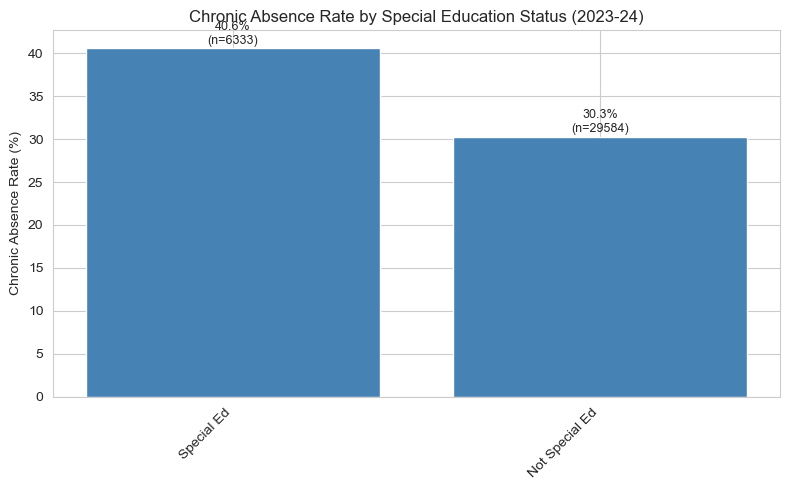

In [8]:
plot_chronic_rate_by('SpEd', 'Chronic Absence Rate by Special Education Status (2023-24)', figsize=(8, 5))

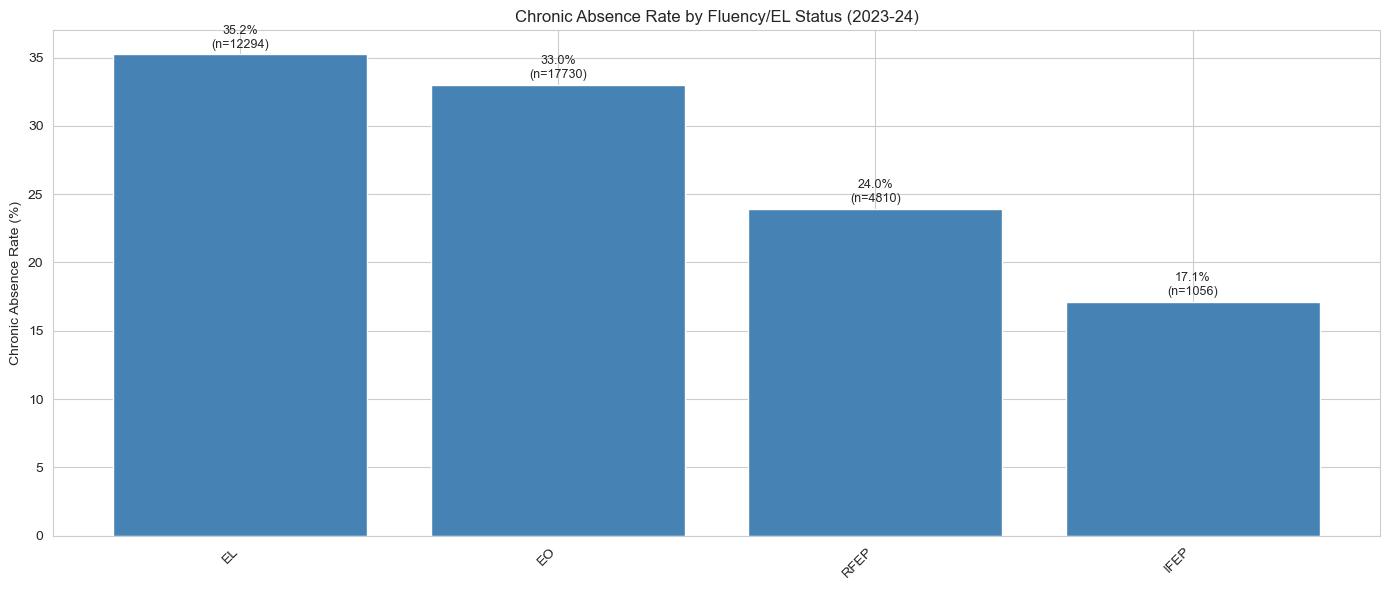

In [9]:
plot_chronic_rate_by('Fluency', 'Chronic Absence Rate by Fluency/EL Status (2023-24)')

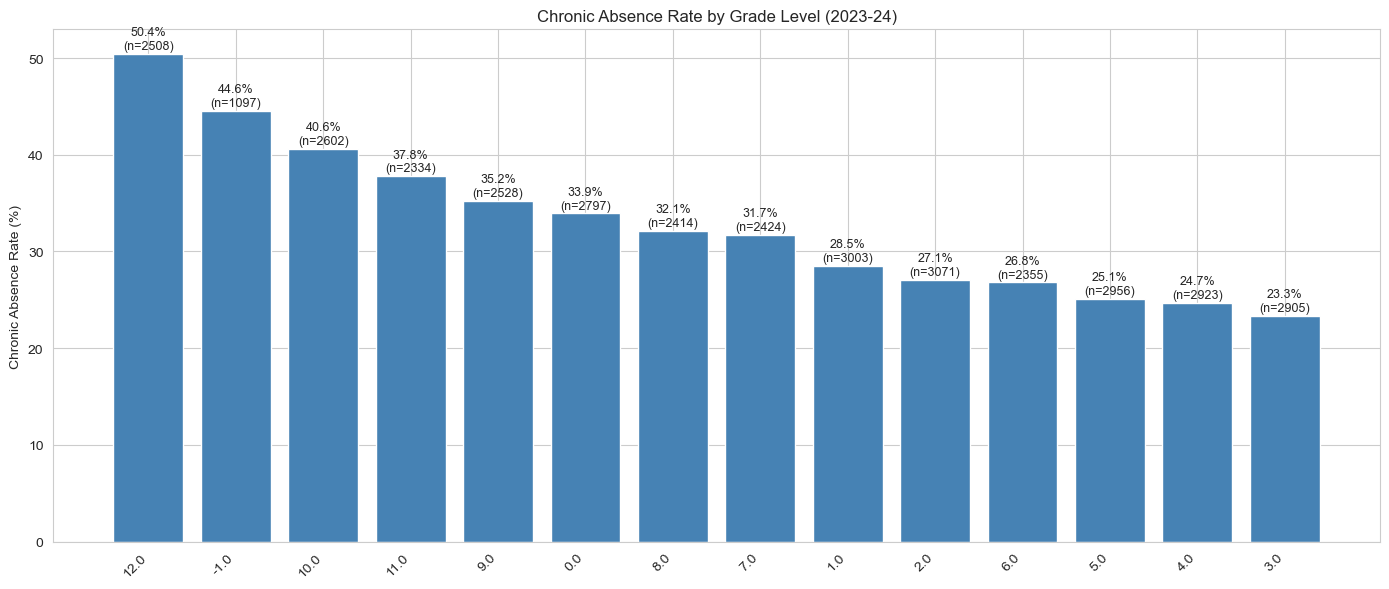

In [10]:
plot_chronic_rate_by('Grade', 'Chronic Absence Rate by Grade Level (2023-24)')

## 4. Attendance & Academic Distributions (2023-24)

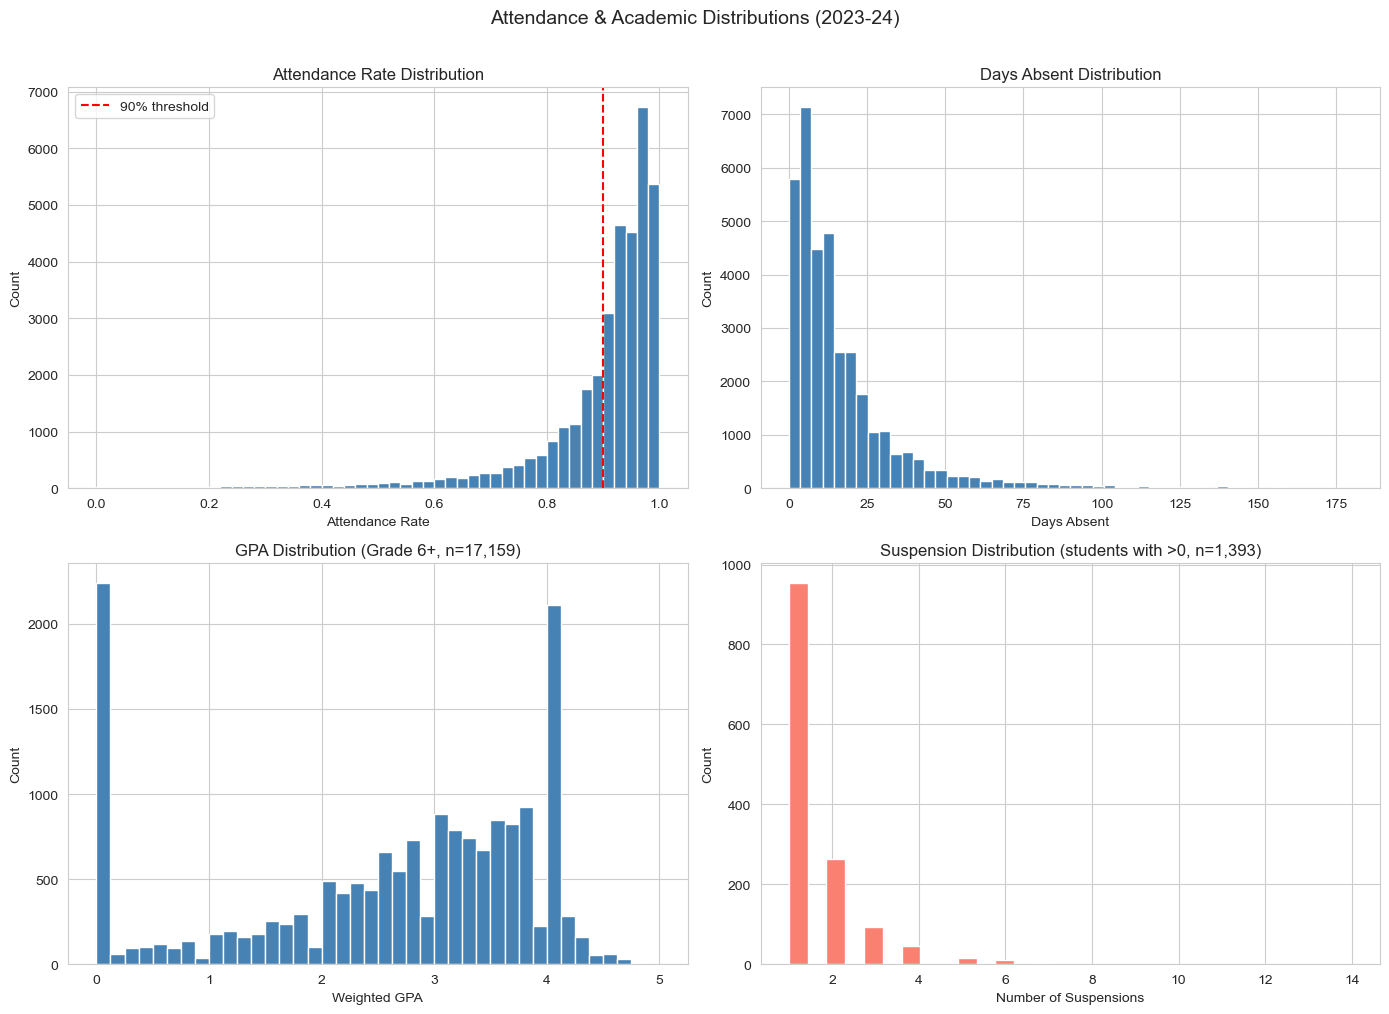

Students with 0 suspensions: 34,524 / 35,917 (96.1%)


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# AttRate histogram
axes[0, 0].hist(df24['AttRate'].dropna(), bins=50, color='steelblue', edgecolor='white')
axes[0, 0].axvline(0.9, color='red', linestyle='--', label='90% threshold')
axes[0, 0].set_title('Attendance Rate Distribution')
axes[0, 0].set_xlabel('Attendance Rate')
axes[0, 0].legend()

# DaysAbs histogram
axes[0, 1].hist(df24['DaysAbs'].dropna(), bins=50, color='steelblue', edgecolor='white')
axes[0, 1].set_title('Days Absent Distribution')
axes[0, 1].set_xlabel('Days Absent')

# GPA distribution (secondary students, grade >= 6)
gpa_data = df24[(df24['Grade'] >= 6) & (df24['CurrWeightedTotGPA'].notna())]['CurrWeightedTotGPA']
axes[1, 0].hist(gpa_data, bins=40, color='steelblue', edgecolor='white')
axes[1, 0].set_title(f'GPA Distribution (Grade 6+, n={len(gpa_data):,})')
axes[1, 0].set_xlabel('Weighted GPA')

# Suspensions distribution
susp_data = df24['Susp'].dropna()
axes[1, 1].hist(susp_data[susp_data > 0], bins=30, color='salmon', edgecolor='white')
axes[1, 1].set_title(f'Suspension Distribution (students with >0, n={int((susp_data > 0).sum()):,})')
axes[1, 1].set_xlabel('Number of Suspensions')

for ax in axes.flat:
    ax.set_ylabel('Count')

plt.suptitle('Attendance & Academic Distributions (2023-24)', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print(f'Students with 0 suspensions: {int((susp_data == 0).sum()):,} / {len(susp_data):,} ({(susp_data == 0).mean()*100:.1f}%)')

## 5. School-Level Drill-Down

In [12]:
# School-level stats for 2023-24 (schools with >= 50 enrolled students)
school_stats = df24.groupby('SiteName').agg(
    enrollment=('ANON_ID', 'count'),
    chronic_rate=('chronic_absent', 'mean'),
    mean_att_rate=('AttRate', 'mean'),
    mean_days_abs=('DaysAbs', 'mean'),
    mean_susp=('Susp', 'mean'),
).reset_index()
school_stats['chronic_rate'] *= 100
school_stats['mean_att_rate'] *= 100 if school_stats['mean_att_rate'].max() <= 1 else 1

school_stats_50 = school_stats[school_stats['enrollment'] >= 50].sort_values('enrollment', ascending=False)
top20 = school_stats_50.head(20).copy()

print(f'Schools with >= 50 students: {len(school_stats_50)}')
print(f'\nTop 20 schools by enrollment:')
display(top20[['SiteName', 'enrollment', 'chronic_rate', 'mean_att_rate']]
        .rename(columns={'chronic_rate': 'Chronic %', 'mean_att_rate': 'Mean AttRate'})
        .round(1).reset_index(drop=True))

Schools with >= 50 students: 75

Top 20 schools by enrollment:


,SiteName,enrollment,Chronic %,Mean AttRate
0,Oakland Technical High School,1889,25.5,90.8
1,Oakland High School,1625,26.1,90.5
2,Skyline High School,1496,36.6,88.1
3,Fremont High School,1249,38.8,86.5
4,Coliseum College Prep Academy,856,29.9,90.5
5,Castlemont High School,835,58.1,80.4
6,Edna M Brewer Middle School,832,13.2,94.0
7,Elmhurst United Middle School,819,45.2,87.6
8,Melrose Leadership Academy,734,9.8,94.6
9,Lockwood STEAM Academy,729,35.4,88.9


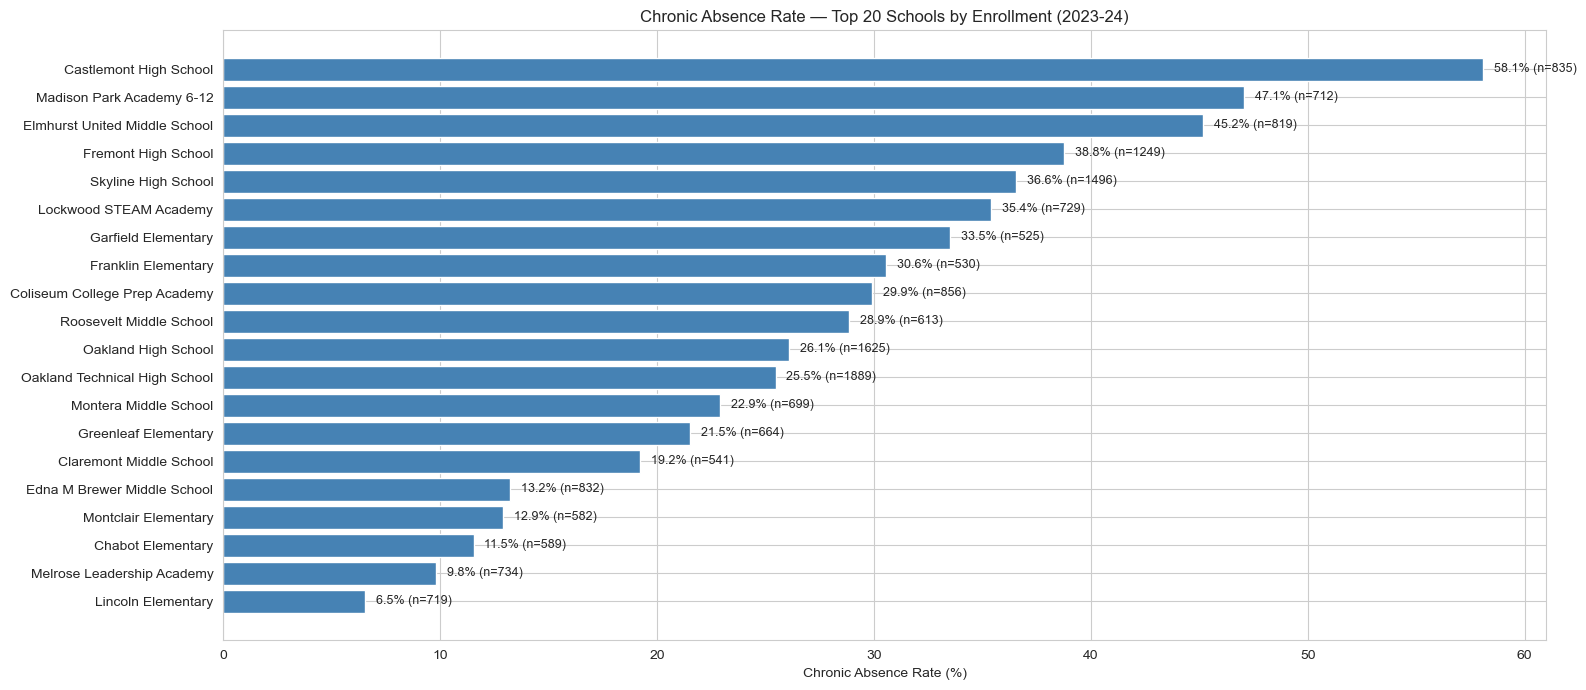

In [13]:
# Bar chart: chronic absence rate for top 20 schools by enrollment
fig, ax = plt.subplots(figsize=(16, 7))
top20_sorted = top20.sort_values('chronic_rate', ascending=True)
ax.barh(top20_sorted['SiteName'], top20_sorted['chronic_rate'], color='steelblue')
for i, (_, row) in enumerate(top20_sorted.iterrows()):
    ax.text(row['chronic_rate'] + 0.5, i, f'{row["chronic_rate"]:.1f}% (n={int(row["enrollment"])})',
            va='center', fontsize=9)
ax.set_xlabel('Chronic Absence Rate (%)')
ax.set_title('Chronic Absence Rate — Top 20 Schools by Enrollment (2023-24)')
plt.tight_layout()
plt.show()

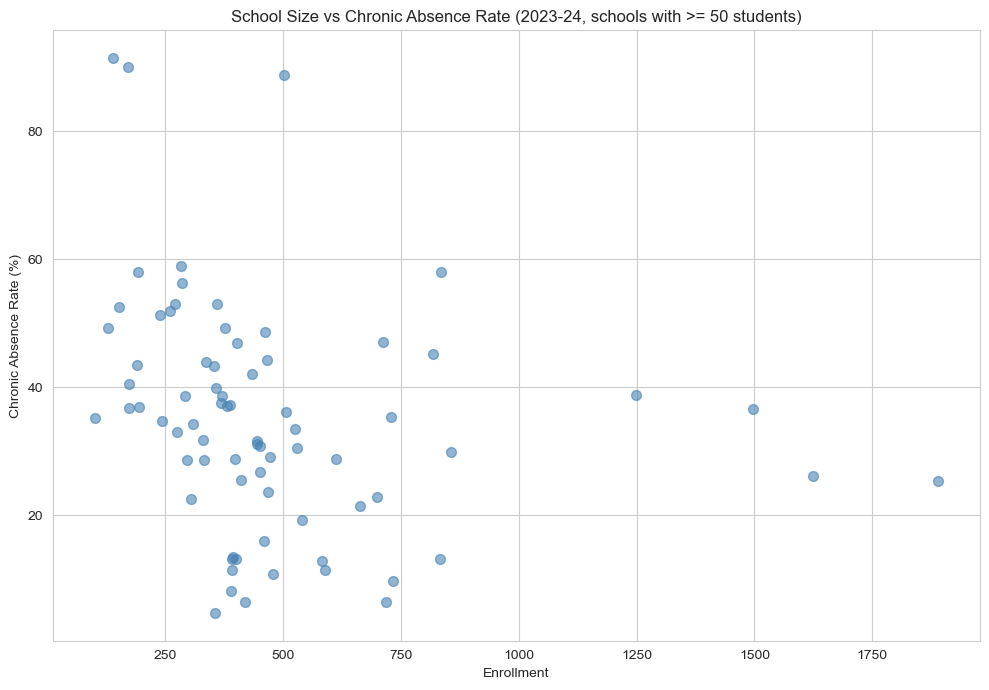

Correlation between enrollment and chronic rate: -0.245


In [14]:
# Scatter: school enrollment vs chronic absence rate
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(school_stats_50['enrollment'], school_stats_50['chronic_rate'],
           alpha=0.6, s=50, color='steelblue')
ax.set_xlabel('Enrollment')
ax.set_ylabel('Chronic Absence Rate (%)')
ax.set_title('School Size vs Chronic Absence Rate (2023-24, schools with >= 50 students)')
plt.tight_layout()
plt.show()

corr = school_stats_50['enrollment'].corr(school_stats_50['chronic_rate'])
print(f'Correlation between enrollment and chronic rate: {corr:.3f}')

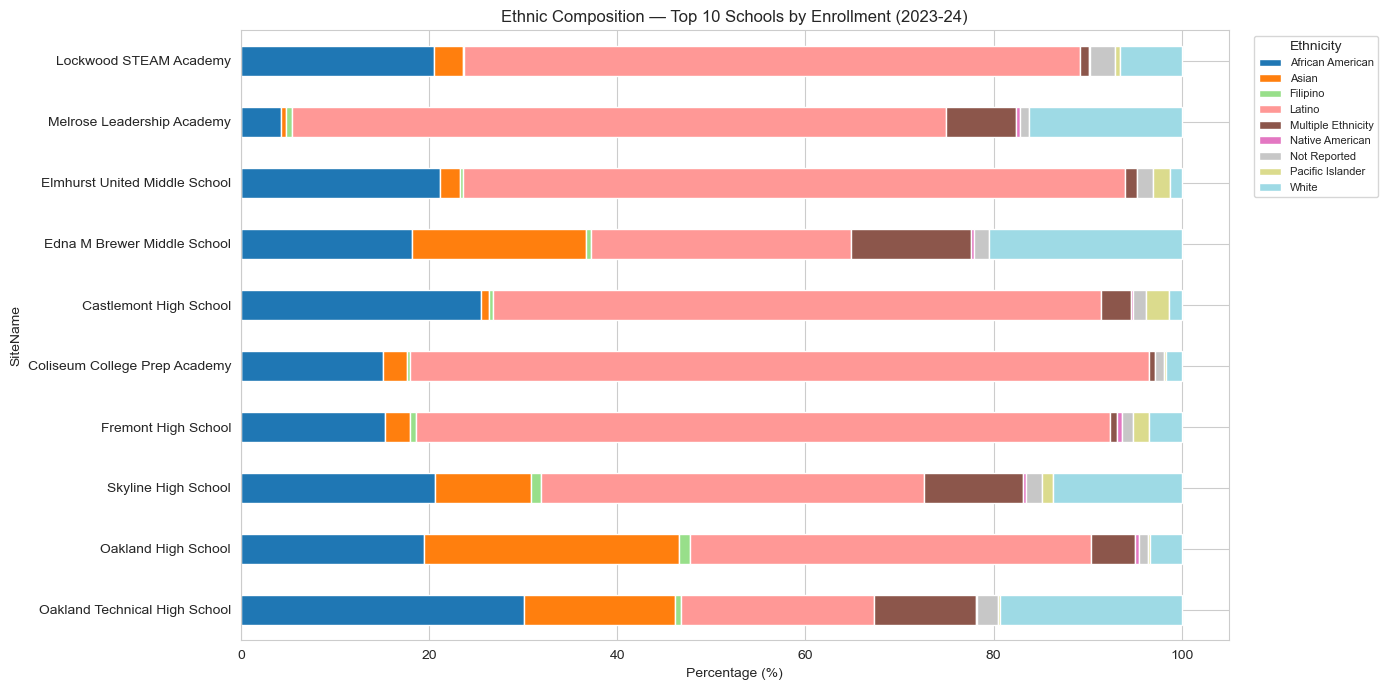

In [15]:
# School-level demographic composition (top 10 schools by enrollment)
top10_names = school_stats_50.head(10)['SiteName'].tolist()
top10_df = df24[df24['SiteName'].isin(top10_names)].copy()

eth_comp = top10_df.groupby(['SiteName', 'Eth']).size().unstack(fill_value=0)
eth_pct = eth_comp.div(eth_comp.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 7))
eth_pct.loc[top10_names].plot(kind='barh', stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Percentage (%)')
ax.set_title('Ethnic Composition — Top 10 Schools by Enrollment (2023-24)')
ax.legend(title='Ethnicity', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

Schools with complete data (all 7 years): 7 / 10
Included: ['Castlemont High School', 'Coliseum College Prep Academy', 'Edna M Brewer Middle School', 'Fremont High School', 'Melrose Leadership Academy', 'Oakland High School', 'Skyline High School']
Excluded (incomplete years): ['Oakland Technical High School', 'Elmhurst United Middle School', 'Lockwood STEAM Academy']


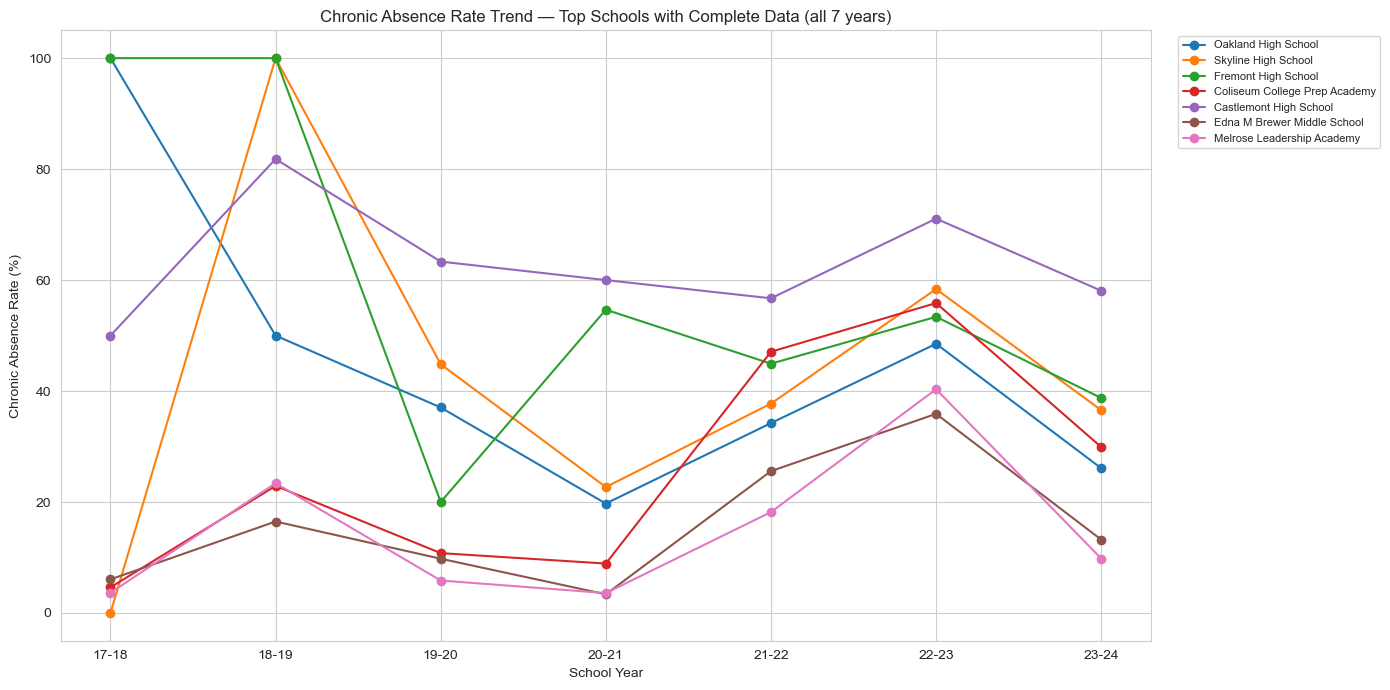

In [16]:
# School-level attendance trend over years (top 10 schools)
enrolled_all = df[df['AttRate'].notna()].copy()
top10_trend = (enrolled_all[enrolled_all['SiteName'].isin(top10_names)]
               .groupby(['year', 'SiteName'])['chronic_absent'].mean() * 100)
top10_trend = top10_trend.reset_index()

year_map = {1718: '17-18', 1819: '18-19', 1920: '19-20',
            2021: '20-21', 2122: '21-22', 2223: '22-23', 2324: '23-24'}
top10_trend['year_label'] = top10_trend['year'].map(year_map)

# Only keep schools that have data for all 7 years
years_per_school = top10_trend.groupby('SiteName')['year'].nunique()
complete_schools = years_per_school[years_per_school == 7].index.tolist()
top10_trend_complete = top10_trend[top10_trend['SiteName'].isin(complete_schools)]

print(f'Schools with complete data (all 7 years): {len(complete_schools)} / {len(top10_names)}')
print(f'Included: {complete_schools}')
excluded = [s for s in top10_names if s not in complete_schools]
if excluded:
    print(f'Excluded (incomplete years): {excluded}')

fig, ax = plt.subplots(figsize=(14, 7))
for site in [s for s in top10_names if s in complete_schools]:
    site_data = top10_trend_complete[top10_trend_complete['SiteName'] == site]
    ax.plot(site_data['year_label'], site_data['chronic_absent'], marker='o', label=site)
ax.set_ylabel('Chronic Absence Rate (%)')
ax.set_xlabel('School Year')
ax.set_title('Chronic Absence Rate Trend — Top Schools with Complete Data (all 7 years)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

## 6. Correlation Heatmaps

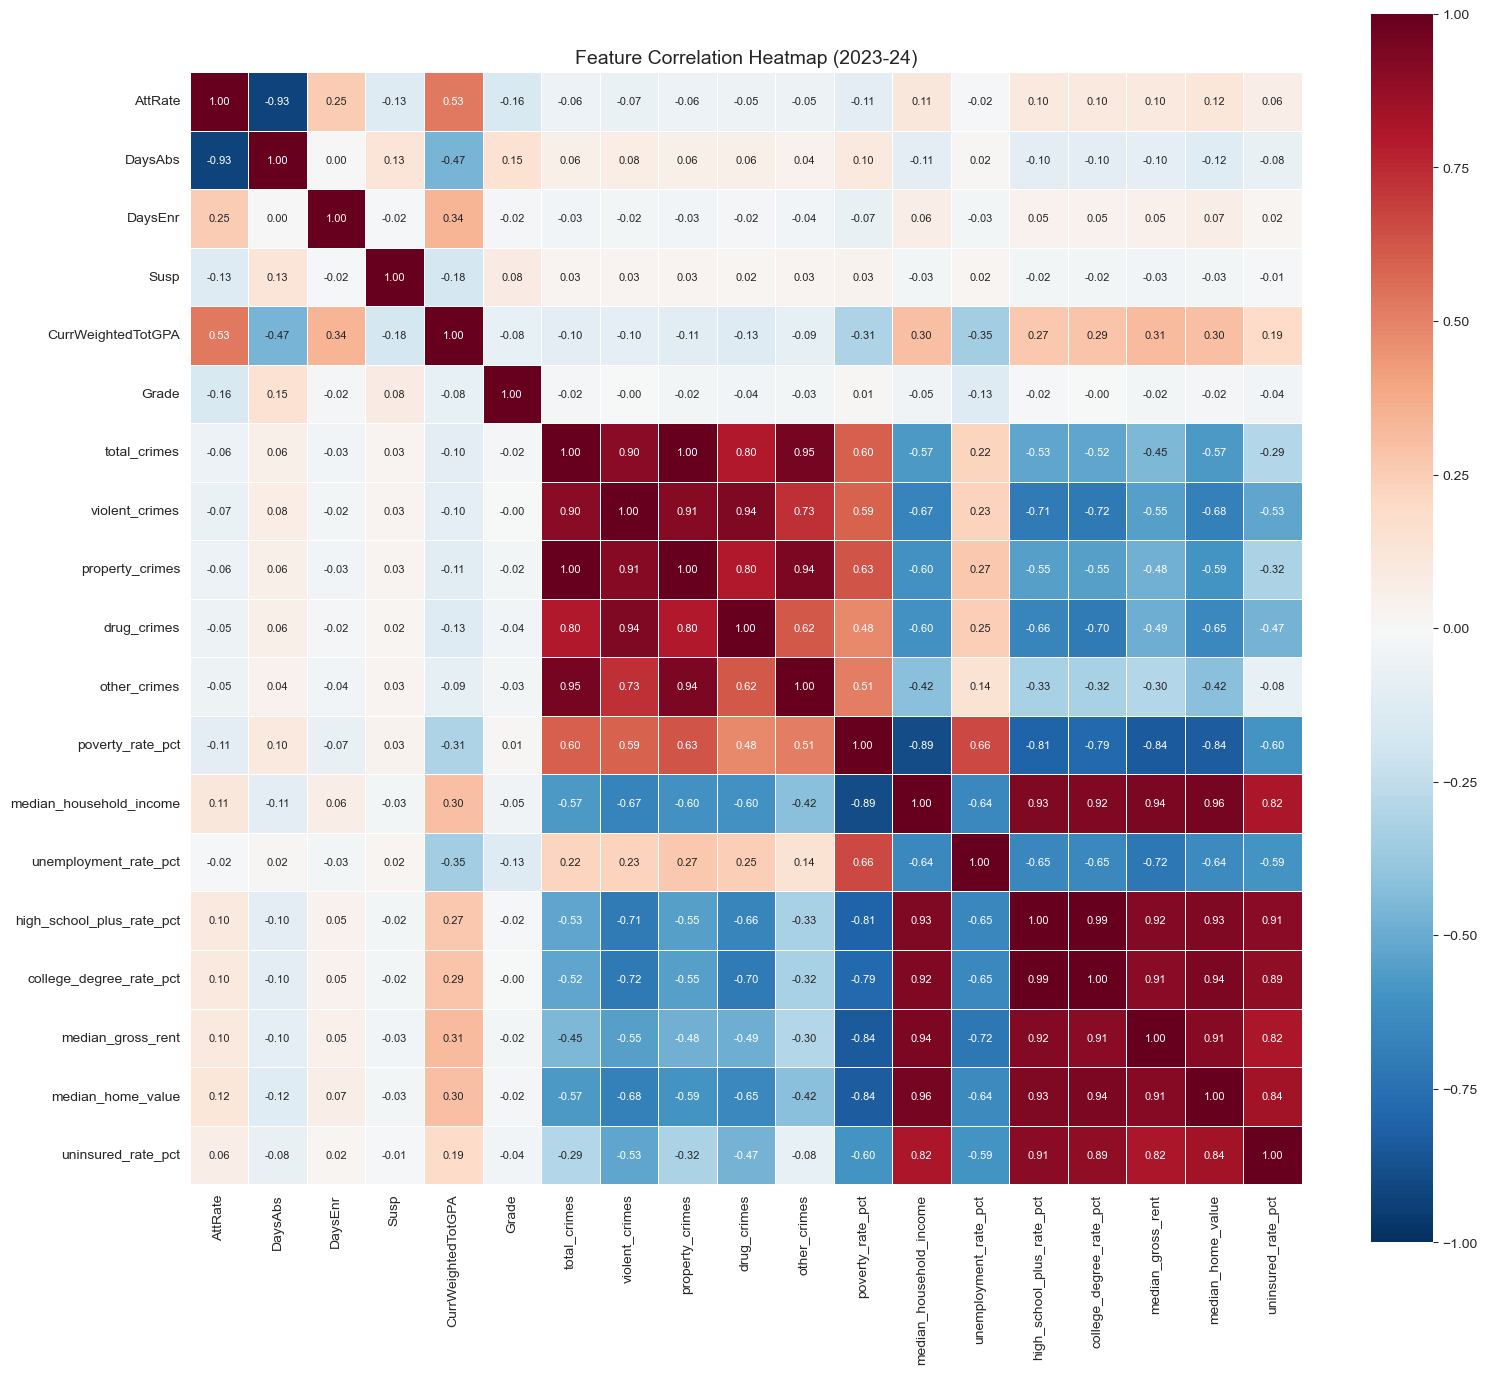

In [17]:
# Numeric feature correlation heatmap (2023-24 enrolled)
numeric_cols = ['AttRate', 'DaysAbs', 'DaysEnr', 'Susp', 'CurrWeightedTotGPA', 'Grade',
                'total_crimes', 'violent_crimes', 'property_crimes', 'drug_crimes', 'other_crimes',
                'poverty_rate_pct', 'median_household_income', 'unemployment_rate_pct',
                'high_school_plus_rate_pct', 'college_degree_rate_pct',
                'median_gross_rent', 'median_home_value', 'uninsured_rate_pct']

corr_matrix = df24[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 8})
ax.set_title('Feature Correlation Heatmap (2023-24)', fontsize=14)
plt.tight_layout()
plt.show()

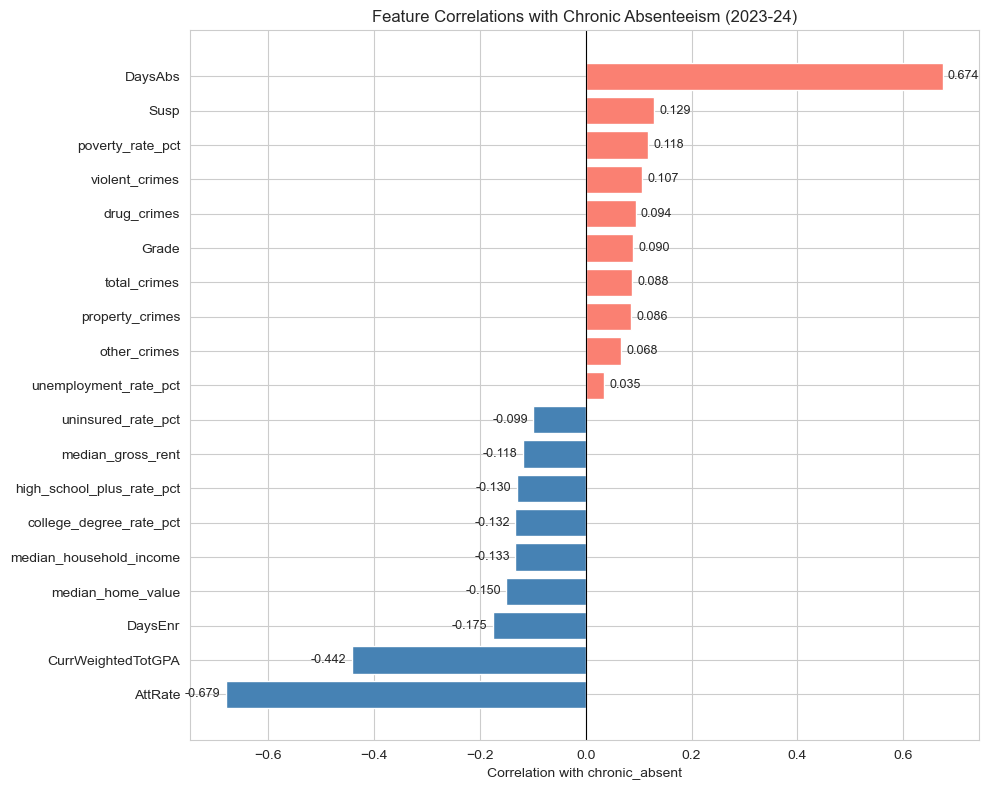

In [18]:
# Correlation with chronic_absent target
target_corr = df24[numeric_cols + ['chronic_absent']].corr()['chronic_absent'].drop('chronic_absent')
target_corr = target_corr.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['salmon' if v > 0 else 'steelblue' for v in target_corr.values]
ax.barh(target_corr.index, target_corr.values, color=colors)
ax.set_xlabel('Correlation with chronic_absent')
ax.set_title('Feature Correlations with Chronic Absenteeism (2023-24)')
ax.axvline(0, color='black', linewidth=0.8)
for i, v in enumerate(target_corr.values):
    ax.text(v + (0.01 if v >= 0 else -0.01), i, f'{v:.3f}',
            va='center', ha='left' if v >= 0 else 'right', fontsize=9)
plt.tight_layout()
plt.show()

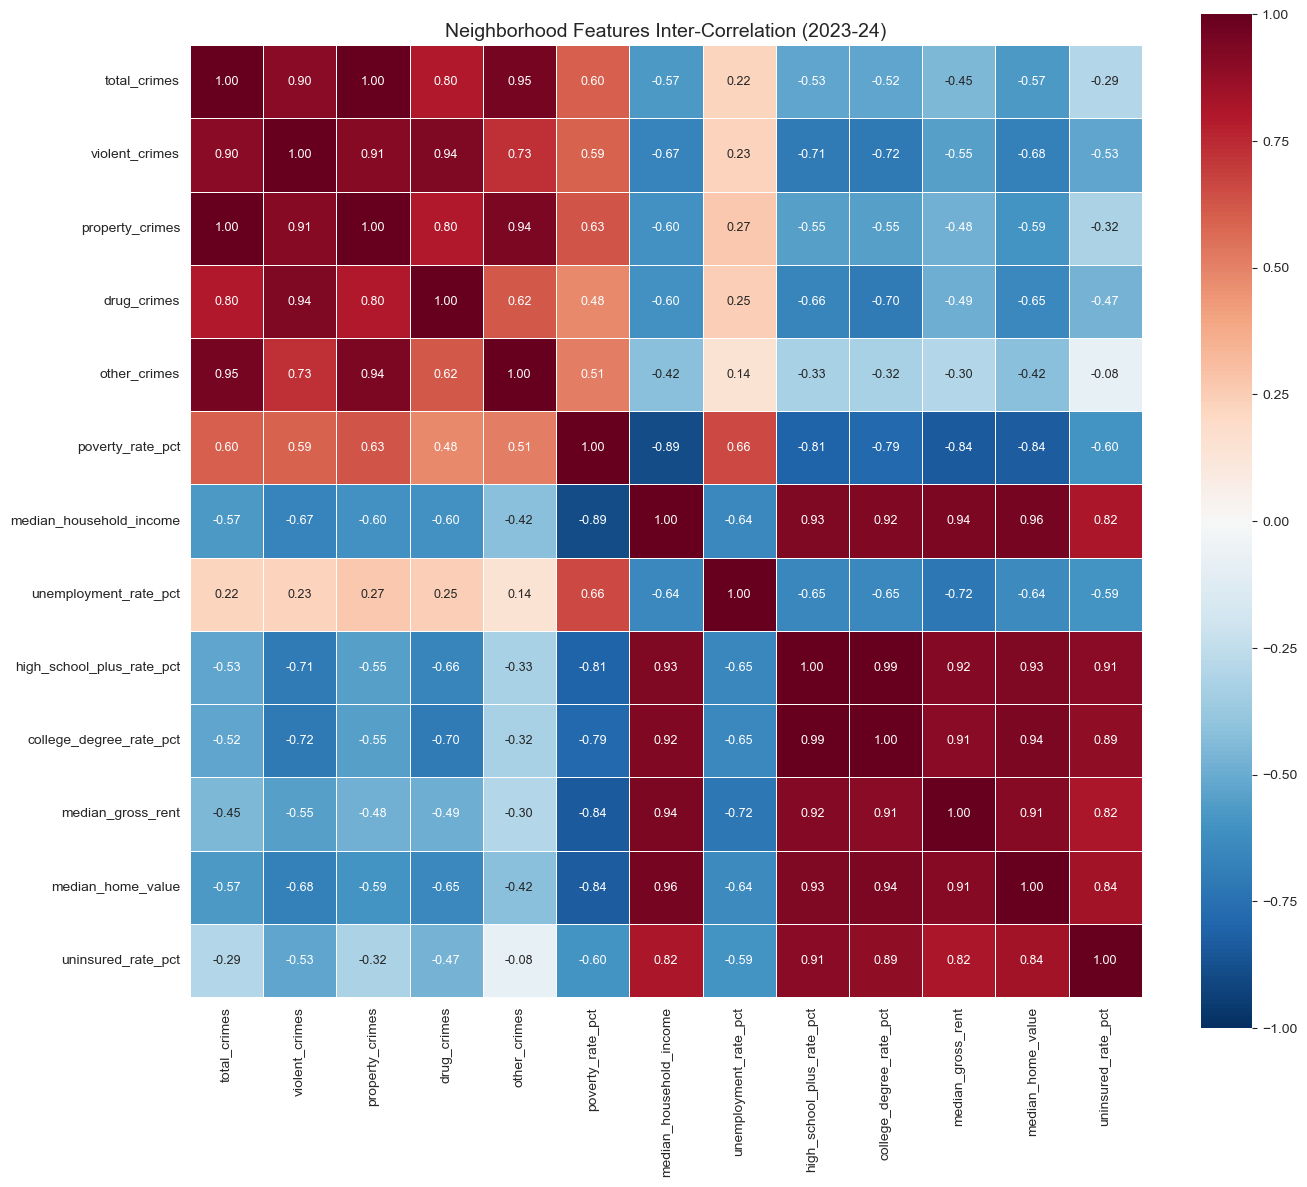

In [19]:
# Neighborhood features inter-correlation heatmap
neighborhood_cols = ['total_crimes', 'violent_crimes', 'property_crimes', 'drug_crimes', 'other_crimes',
                     'poverty_rate_pct', 'median_household_income', 'unemployment_rate_pct',
                     'high_school_plus_rate_pct', 'college_degree_rate_pct',
                     'median_gross_rent', 'median_home_value', 'uninsured_rate_pct']

neigh_corr = df24[neighborhood_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(neigh_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 9})
ax.set_title('Neighborhood Features Inter-Correlation (2023-24)', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Neighborhood Features vs Chronic Absence

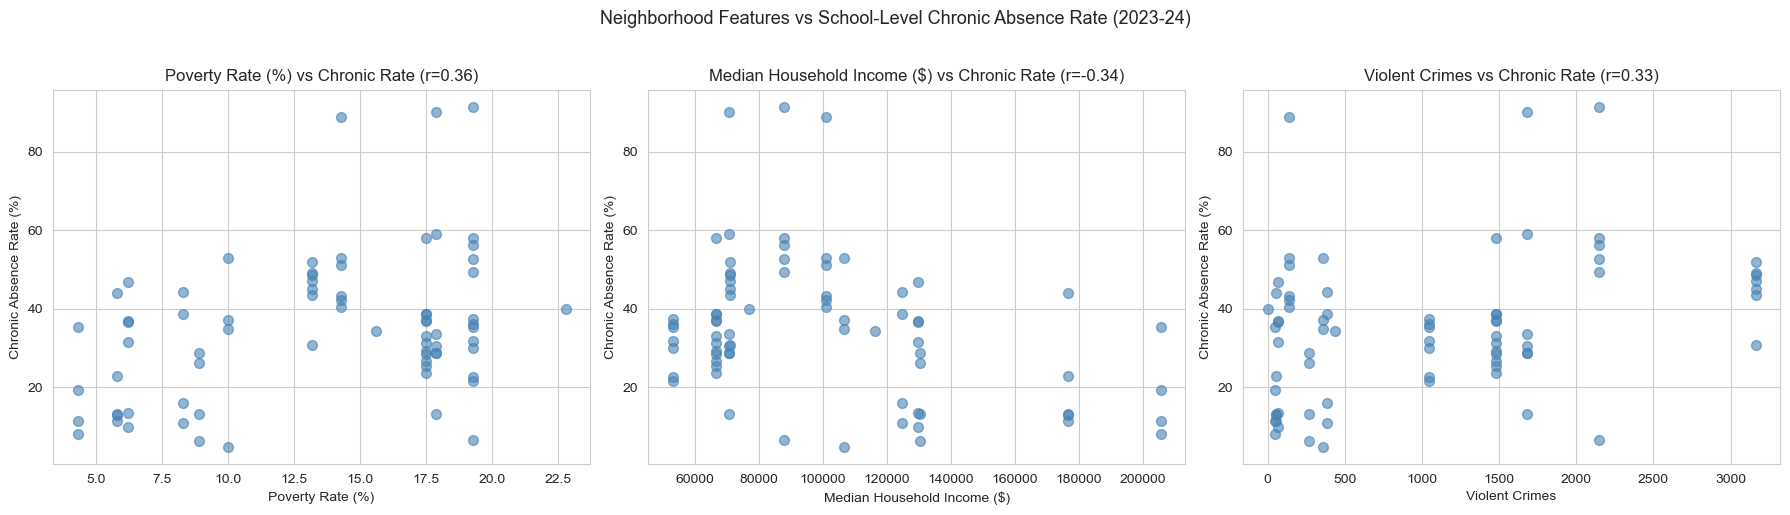

In [20]:
# Scatter: neighborhood features vs school-level chronic absence rate
school_neigh = df24.groupby('SiteName').agg(
    chronic_rate=('chronic_absent', 'mean'),
    enrollment=('ANON_ID', 'count'),
    poverty_rate_pct=('poverty_rate_pct', 'mean'),
    median_household_income=('median_household_income', 'mean'),
    violent_crimes=('violent_crimes', 'mean'),
).reset_index()
school_neigh['chronic_rate'] *= 100
school_neigh = school_neigh[school_neigh['enrollment'] >= 50]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, label in zip(axes,
    ['poverty_rate_pct', 'median_household_income', 'violent_crimes'],
    ['Poverty Rate (%)', 'Median Household Income ($)', 'Violent Crimes']):
    ax.scatter(school_neigh[col], school_neigh['chronic_rate'],
               alpha=0.6, s=50, color='steelblue')
    ax.set_xlabel(label)
    ax.set_ylabel('Chronic Absence Rate (%)')
    r = school_neigh[col].corr(school_neigh['chronic_rate'])
    ax.set_title(f'{label} vs Chronic Rate (r={r:.2f})')

plt.suptitle('Neighborhood Features vs School-Level Chronic Absence Rate (2023-24)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

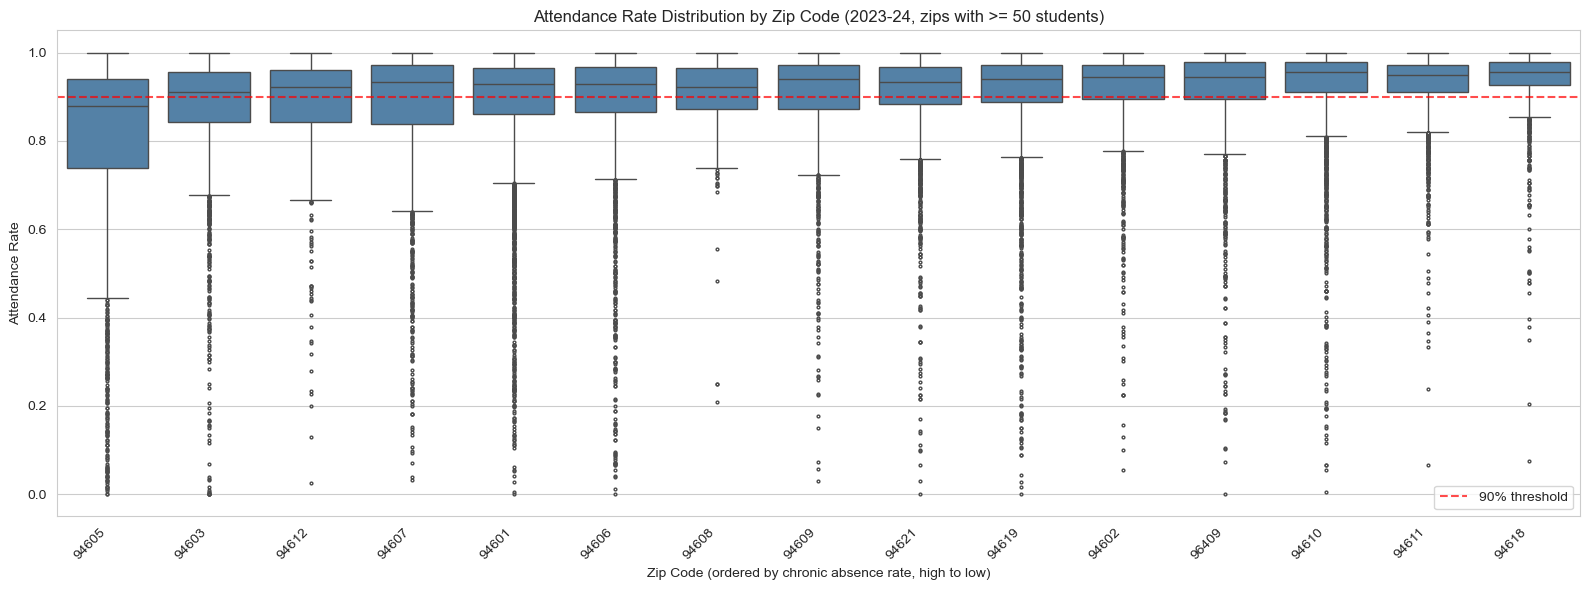

Chronic absence rate by zip code:


,n,chronic_rate,mean_att
Zip,,,
94605,2013,56.9,0.796
94603,3023,44.7,0.874
94612,358,39.9,0.865
94607,1867,38.2,0.871
94601,5889,36.1,0.883
94606,2819,34.6,0.883
94608,310,34.5,0.901
94609,1347,32.4,0.892
94621,3760,30.6,0.906


In [21]:
# Box plot: chronic absence rate by zip code (zips with >= 50 students)
zip_counts = df24['Zip'].value_counts()
valid_zips = zip_counts[zip_counts >= 50].index
df24_zip = df24[df24['Zip'].isin(valid_zips)].copy()
df24_zip['Zip'] = df24_zip['Zip'].astype(int).astype(str)

# Order zips by median chronic rate
zip_order = (df24_zip.groupby('Zip')['chronic_absent'].mean()
             .sort_values(ascending=False).index.tolist())

fig, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(data=df24_zip, x='Zip', y='AttRate', order=zip_order, ax=ax,
            color='steelblue', fliersize=2)
ax.axhline(0.9, color='red', linestyle='--', alpha=0.7, label='90% threshold')
ax.set_xlabel('Zip Code (ordered by chronic absence rate, high to low)')
ax.set_ylabel('Attendance Rate')
ax.set_title('Attendance Rate Distribution by Zip Code (2023-24, zips with >= 50 students)')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary table
zip_summary = df24_zip.groupby('Zip').agg(
    n=('ANON_ID', 'count'),
    chronic_rate=('chronic_absent', 'mean'),
    mean_att=('AttRate', 'mean')
).sort_values('chronic_rate', ascending=False)
zip_summary['chronic_rate'] = (zip_summary['chronic_rate'] * 100).round(1)
zip_summary['mean_att'] = zip_summary['mean_att'].round(3)
print('Chronic absence rate by zip code:')
display(zip_summary)